In [1]:
import os, sys, subprocess, glob, json
from pathlib import Path

def find_project_root(start: Path) -> Path:
    # Cherche un dossier parent contenant src/train_torch.py
    for p in [start, *start.parents]:
        if (p / "src").is_dir() and (p / "src" / "train_torch.py").exists():
            return p
    return start

# 1) Se placer au bon endroit
cwd = Path.cwd()
root = find_project_root(cwd)
print("Notebook CWD:", cwd)
print("Project root utilisé:", root)
os.chdir(root)

# 2) Lancer l'entraînement + sauvegarde des prédictions
cmd = [sys.executable, "-m", "src.train_torch", "--save_pred"]
print("\nCommande:", " ".join(cmd))
proc = subprocess.run(cmd, capture_output=True, text=True)

print("\n--- STDOUT ---")
print(proc.stdout)
print("\n--- STDERR ---")
print(proc.stderr)

if proc.returncode != 0:
    raise RuntimeError(f"Erreur d'exécution (code {proc.returncode}). Voir STDERR ci-dessus.")

# 3) Retrouver les fichiers créés (les plus récents)
jsons = sorted(glob.glob("results_torch_*.json"), key=os.path.getmtime)
npzs  = sorted(glob.glob("preds_torch_*.npz"),  key=os.path.getmtime)

latest_json = jsons[-1] if jsons else None
latest_npz  = npzs[-1]  if npzs else None

print("\nFichiers générés:")
print(" - Results JSON:", latest_json)
print(" - Predictions NPZ:", latest_npz)

# 4) Afficher un résumé (sans imprimer tout le package)
if latest_json:
    with open(latest_json, "r", encoding="utf-8") as f:
        R = json.load(f)
    print("\nRésumé:")
    print(" - Classification:", R["results"]["classification"]["mlp"])
    print(" - Régression:", R["results"]["regression"]["mlp"])


Notebook CWD: C:\Users\Moham\PycharmProjects\DL_Popularity\src
Project root utilisé: C:\Users\Moham\PycharmProjects\DL_Popularity

Commande: C:\Users\Moham\anaconda3\python.exe -m src.train_torch --save_pred

--- STDOUT ---
Using CPU
Loading dataset...
Creating train/val/test split...
Training data: 27750 samples, 59 features
Class distribution - Train: 0.252, Val: 0.252, Test: 0.252
Training classifier...
Early stopping at epoch 35
Training regressor...
Early stopping at epoch 35

FINAL RESULTS (summary)
Classification: {'accuracy': 0.724062552547503, 'f1_macro': 0.6367213843873565, 'confusion_matrix': [[3611, 838], [803, 695]]}
Regression: {'r2_y1': 0.16340260050084876, 'rmse_y1': 0.8473433996407902, 'mae_y1': 0.6297193130783821, 'r2_y2': 0.16456440688219487, 'rmse_y2': 0.8278749089149875, 'mae_y2': 0.6253015805985124, 'r2_y3': 0.19865344060301438, 'rmse_y3': 0.25747620928375275, 'mae_y3': 0.21506914434167773, 'r2_mean': 0.175540149328686}

Results saved to results_torch_42.json
Pred

Loaded: results_torch_42.json and preds_torch_42.npz


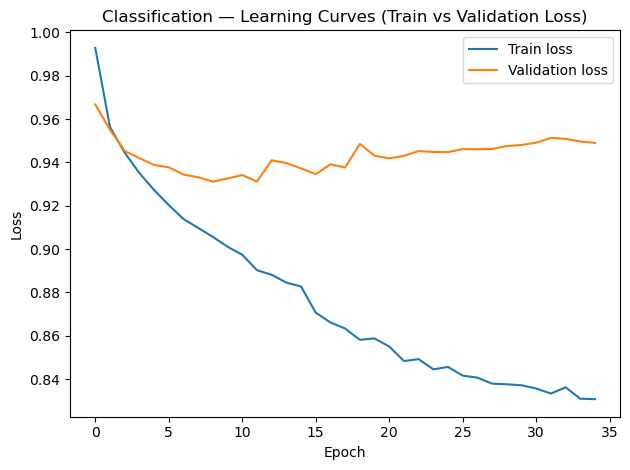

Purpose: Diagnose optimization and overfitting/underfitting for the classifier.
How to read: If train loss keeps decreasing while validation loss stops improving or increases, the model is overfitting. If both plateau early at high values, the model may be underfitting.
Idea: Early stopping typically triggers when validation stops improving, preventing overfit.
------------------------------------------------------------------------------------------


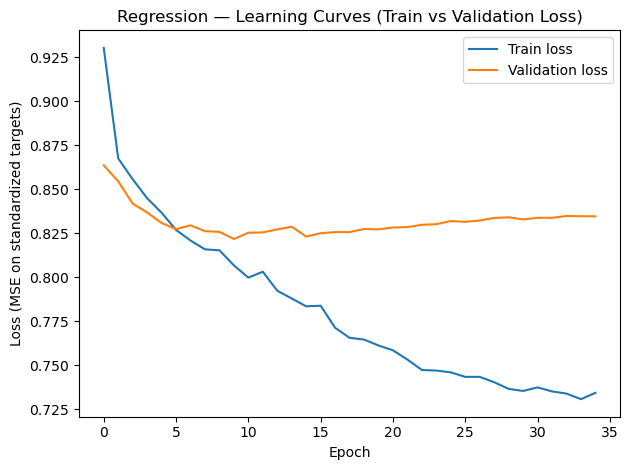

Purpose: Diagnose optimization and generalization for the multi-output regressor.
How to read: Loss here is MSE computed on standardized targets, so it is comparable across outputs.
Idea: A stable gap (train < val) is normal. A growing gap indicates overfitting; both flat high indicates underfitting or insufficient features.
------------------------------------------------------------------------------------------


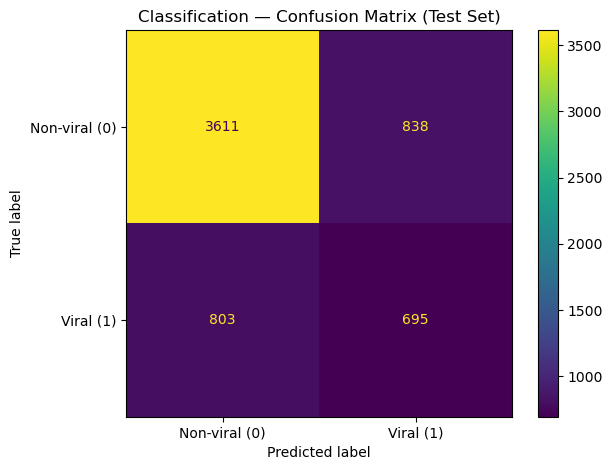

Purpose: Show the types of classification errors.
How to read: Rows = true class, Columns = predicted class.
 - Top-left (TN): correctly predicted non-viral.
 - Bottom-right (TP): correctly predicted viral.
 - Top-right (FP): predicted viral but actually non-viral.
 - Bottom-left (FN): predicted non-viral but actually viral.
Idea: For imbalanced data, this is more informative than accuracy alone.
------------------------------------------------------------------------------------------


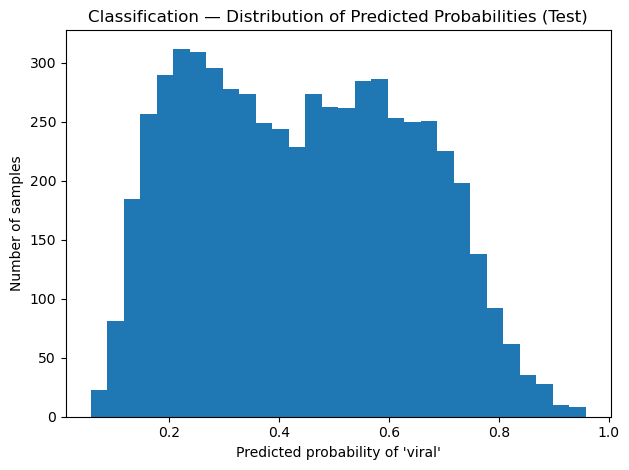

Purpose: Check model confidence and calibration behavior.
How to read: A strong model often separates probabilities toward 0 and 1. If most values cluster near 0.5, the classifier is uncertain.
Idea: This helps justify threshold tuning (choosing a decision cutoff different from 0.5).
------------------------------------------------------------------------------------------


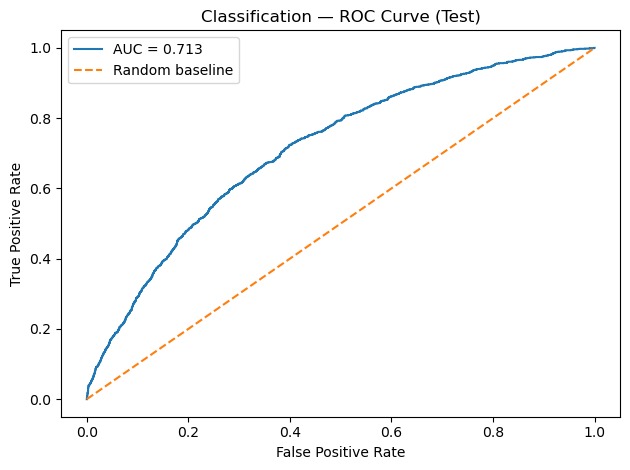

Purpose: Evaluate ranking quality across all thresholds.
How to read: The curve shows TPR vs FPR for every possible threshold. AUC summarizes the curve: 0.5 = random, 1.0 = perfect ranking.
Idea: ROC is useful, but with class imbalance, Precision–Recall can be more informative.
------------------------------------------------------------------------------------------


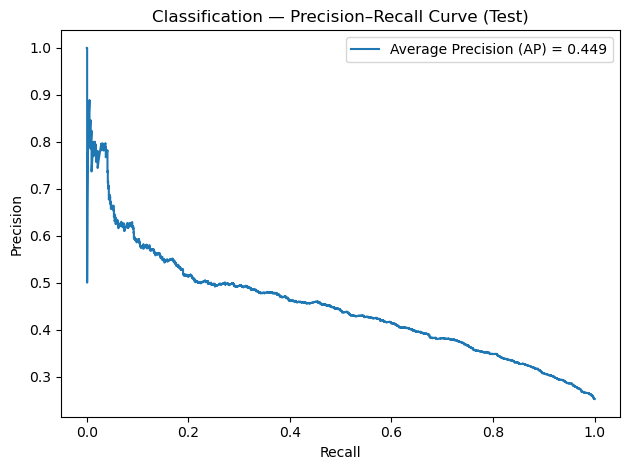

Purpose: Evaluate performance on the positive (viral) class under imbalance.
How to read: Precision measures how many predicted virals are correct; Recall measures how many true virals are found.
Idea: PR curves are often preferred for imbalanced datasets because they focus on the positive class.
------------------------------------------------------------------------------------------


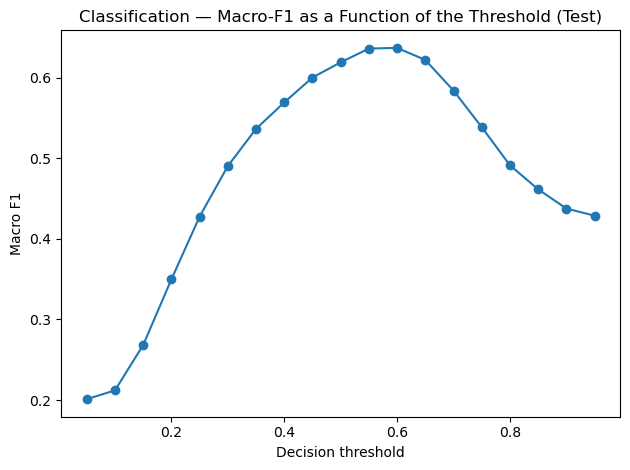

Purpose: Visualize why the chosen threshold may not be 0.5.
How to read: The peak indicates the threshold that best balances classes under macro-F1.
Idea: This supports your project decision to tune the threshold on validation (and then apply it to test).
------------------------------------------------------------------------------------------


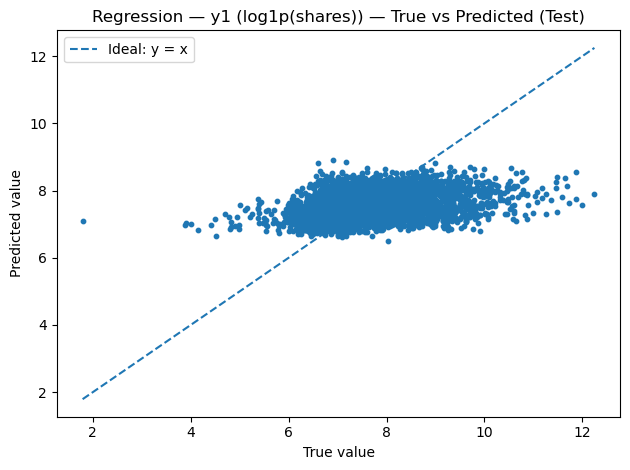

Purpose: Check how close predictions are to ground truth.
How to read: Points close to the diagonal mean good predictions. Systematic deviations indicate bias (e.g., underpredicting high values).
Idea: For heavy-tailed original shares, using log targets makes this plot much more learnable.
------------------------------------------------------------------------------------------


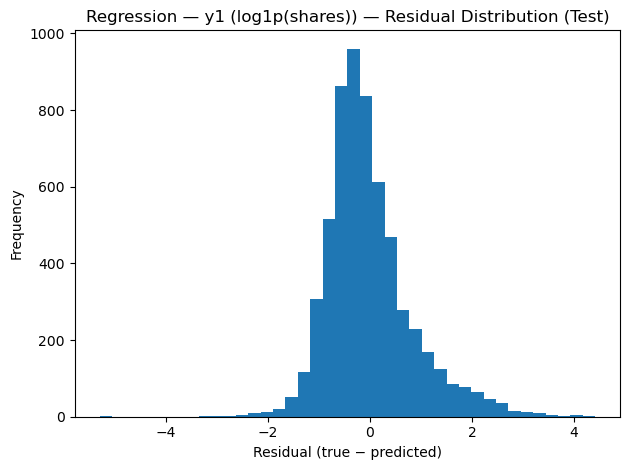

Purpose: Diagnose error structure.
How to read: Ideally residuals center around 0 and are roughly symmetric. Skew or long tails indicate that some ranges are harder.
Idea: Residual analysis helps explain limitations: popularity depends on external factors not in features.
------------------------------------------------------------------------------------------


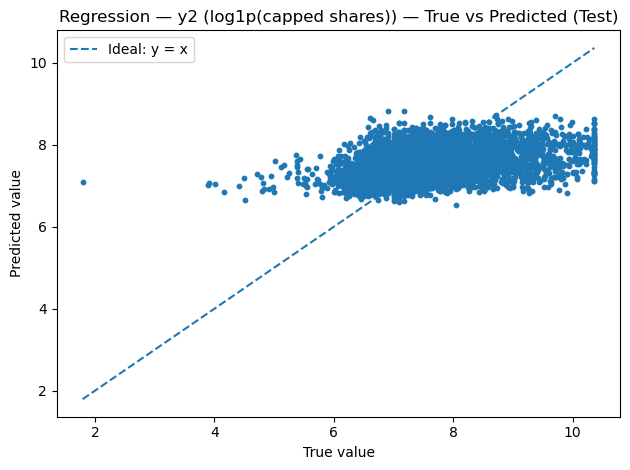

Purpose: Check how close predictions are to ground truth.
How to read: Points close to the diagonal mean good predictions. Systematic deviations indicate bias (e.g., underpredicting high values).
Idea: For heavy-tailed original shares, using log targets makes this plot much more learnable.
------------------------------------------------------------------------------------------


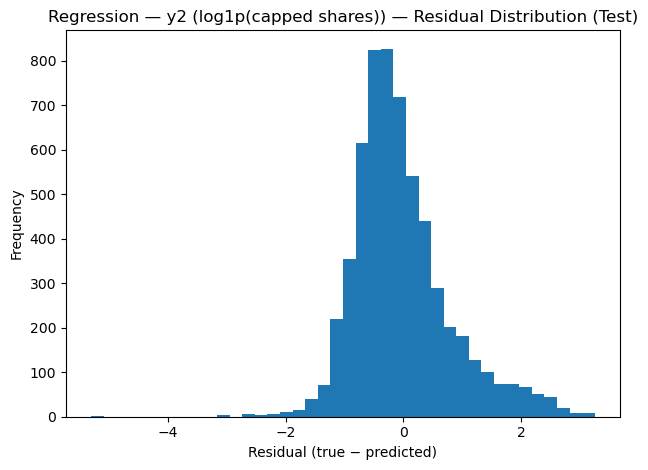

Purpose: Diagnose error structure.
How to read: Ideally residuals center around 0 and are roughly symmetric. Skew or long tails indicate that some ranges are harder.
Idea: Residual analysis helps explain limitations: popularity depends on external factors not in features.
------------------------------------------------------------------------------------------


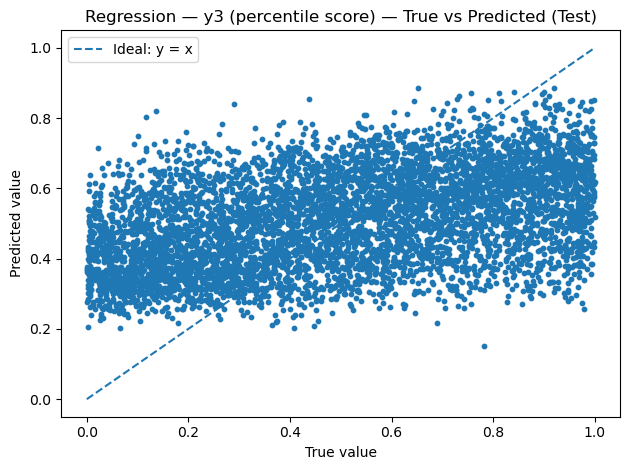

Purpose: Check how close predictions are to ground truth.
How to read: Points close to the diagonal mean good predictions. Systematic deviations indicate bias (e.g., underpredicting high values).
Idea: For heavy-tailed original shares, using log targets makes this plot much more learnable.
------------------------------------------------------------------------------------------


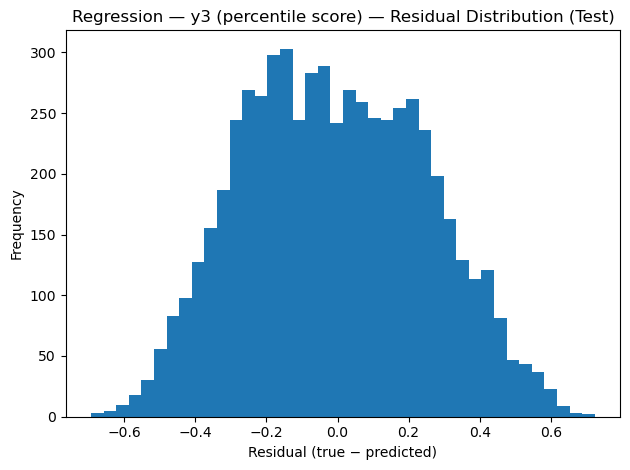

Purpose: Diagnose error structure.
How to read: Ideally residuals center around 0 and are roughly symmetric. Skew or long tails indicate that some ranges are harder.
Idea: Residual analysis helps explain limitations: popularity depends on external factors not in features.
------------------------------------------------------------------------------------------


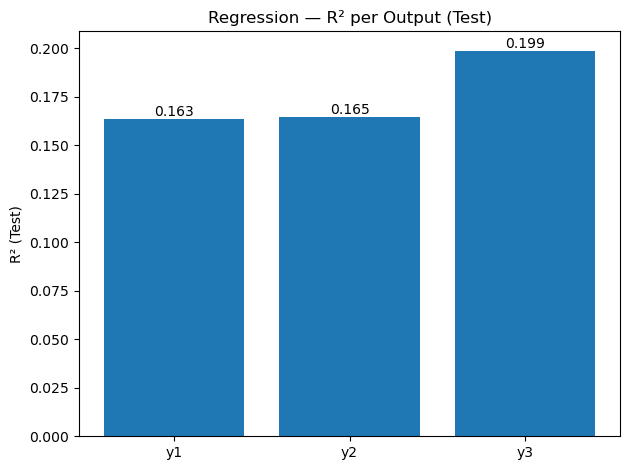

Purpose: Summarize how much variance is explained for each regression target.
How to read: R² = 1 is perfect; 0 means no better than predicting the mean; negative means worse than mean.
Idea: With social popularity data, modest R² is common; showing improvements from target engineering is key.
------------------------------------------------------------------------------------------

All figures saved to: figures/


In [3]:
import os, glob, json
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    ConfusionMatrixDisplay,
    roc_curve, auc,
    precision_recall_curve,
    average_precision_score,
    f1_score
)

# ----------------------------
# Helpers
# ----------------------------
def latest_file(pattern: str):
    files = glob.glob(pattern)
    if not files:
        return None
    return sorted(files, key=os.path.getmtime)[-1]

def show_with_explanation(title: str, explanation: str, save_path: str = None):
    plt.title(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()
    print(explanation)
    print("-" * 90)

def safe_bar_labels(ax):
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(f"{h:.3f}", (p.get_x() + p.get_width()/2, h), ha="center", va="bottom")

# ----------------------------
# Locate & load
# ----------------------------
RESULTS_JSON = latest_file("results_torch_*.json")
PREDS_NPZ    = latest_file("preds_torch_*.npz")

if RESULTS_JSON is None:
    raise FileNotFoundError("No results_torch_*.json found. Run the training cell first.")
if PREDS_NPZ is None:
    raise FileNotFoundError("No preds_torch_*.npz found. Run training with: python -m src.train_torch --save_pred")

with open(RESULTS_JSON, "r", encoding="utf-8") as f:
    R = json.load(f)

P = np.load(PREDS_NPZ)

y_test = P["y_test"].astype(int)
proba  = P["proba_test"].astype(float)
pred   = P["pred_test"].astype(int)

Y_test = P["Y_test"].astype(float)      # (n,3)
Y_pred = P["Y_pred_test"].astype(float) # (n,3)

cls = R["results"]["classification"]
reg = R["results"]["regression"]

print("Loaded:", RESULTS_JSON, "and", PREDS_NPZ)

# Output folder
OUT_DIR = "figures"
os.makedirs(OUT_DIR, exist_ok=True)

# ----------------------------
# 1) Learning curves — Classification
# ----------------------------
plt.figure()
plt.plot(cls["train_history"]["train_loss"], label="Train loss")
plt.plot(cls["train_history"]["val_loss"],   label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

show_with_explanation(
    title="Classification — Learning Curves (Train vs Validation Loss)",
    explanation=(
        "Purpose: Diagnose optimization and overfitting/underfitting for the classifier.\n"
        "How to read: If train loss keeps decreasing while validation loss stops improving or increases, "
        "the model is overfitting. If both plateau early at high values, the model may be underfitting.\n"
        "Idea: Early stopping typically triggers when validation stops improving, preventing overfit."
    ),
    save_path=os.path.join(OUT_DIR, "01_classification_learning_curves.png")
)

# ----------------------------
# 2) Learning curves — Regression
# ----------------------------
plt.figure()
plt.plot(reg["train_history"]["train_loss"], label="Train loss")
plt.plot(reg["train_history"]["val_loss"],   label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE on standardized targets)")
plt.legend()

show_with_explanation(
    title="Regression — Learning Curves (Train vs Validation Loss)",
    explanation=(
        "Purpose: Diagnose optimization and generalization for the multi-output regressor.\n"
        "How to read: Loss here is MSE computed on standardized targets, so it is comparable across outputs.\n"
        "Idea: A stable gap (train < val) is normal. A growing gap indicates overfitting; "
        "both flat high indicates underfitting or insufficient features."
    ),
    save_path=os.path.join(OUT_DIR, "02_regression_learning_curves.png")
)

# ----------------------------
# 3) Confusion matrix
# ----------------------------
cm = np.array(cls["mlp"]["confusion_matrix"])
fig, ax = plt.subplots()
ConfusionMatrixDisplay(cm, display_labels=["Non-viral (0)", "Viral (1)"]).plot(ax=ax, values_format="d")

show_with_explanation(
    title="Classification — Confusion Matrix (Test Set)",
    explanation=(
        "Purpose: Show the types of classification errors.\n"
        "How to read: Rows = true class, Columns = predicted class.\n"
        " - Top-left (TN): correctly predicted non-viral.\n"
        " - Bottom-right (TP): correctly predicted viral.\n"
        " - Top-right (FP): predicted viral but actually non-viral.\n"
        " - Bottom-left (FN): predicted non-viral but actually viral.\n"
        "Idea: For imbalanced data, this is more informative than accuracy alone."
    ),
    save_path=os.path.join(OUT_DIR, "03_confusion_matrix.png")
)

# ----------------------------
# 4) Probability distribution
# ----------------------------
plt.figure()
plt.hist(proba, bins=30)
plt.xlabel("Predicted probability of 'viral'")
plt.ylabel("Number of samples")

show_with_explanation(
    title="Classification — Distribution of Predicted Probabilities (Test)",
    explanation=(
        "Purpose: Check model confidence and calibration behavior.\n"
        "How to read: A strong model often separates probabilities toward 0 and 1. "
        "If most values cluster near 0.5, the classifier is uncertain.\n"
        "Idea: This helps justify threshold tuning (choosing a decision cutoff different from 0.5)."
    ),
    save_path=os.path.join(OUT_DIR, "04_probability_histogram.png")
)

# ----------------------------
# 5) ROC curve + AUC
# ----------------------------
fpr, tpr, _ = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

show_with_explanation(
    title="Classification — ROC Curve (Test)",
    explanation=(
        "Purpose: Evaluate ranking quality across all thresholds.\n"
        "How to read: The curve shows TPR vs FPR for every possible threshold. "
        "AUC summarizes the curve: 0.5 = random, 1.0 = perfect ranking.\n"
        "Idea: ROC is useful, but with class imbalance, Precision–Recall can be more informative."
    ),
    save_path=os.path.join(OUT_DIR, "05_ROC_curve.png")
)

# ----------------------------
# 6) Precision-Recall curve + AP
# ----------------------------
prec, rec, _ = precision_recall_curve(y_test, proba)
ap = average_precision_score(y_test, proba)

plt.figure()
plt.plot(rec, prec, label=f"Average Precision (AP) = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

show_with_explanation(
    title="Classification — Precision–Recall Curve (Test)",
    explanation=(
        "Purpose: Evaluate performance on the positive (viral) class under imbalance.\n"
        "How to read: Precision measures how many predicted virals are correct; Recall measures "
        "how many true virals are found.\n"
        "Idea: PR curves are often preferred for imbalanced datasets because they focus on the positive class."
    ),
    save_path=os.path.join(OUT_DIR, "06_PR_curve.png")
)

# ----------------------------
# 7) Macro-F1 vs threshold (on test, just for visualization)
# ----------------------------
thresholds = np.linspace(0.05, 0.95, 19)
f1s = [f1_score(y_test, (proba >= thr).astype(int), average="macro") for thr in thresholds]

plt.figure()
plt.plot(thresholds, f1s, marker="o")
plt.xlabel("Decision threshold")
plt.ylabel("Macro F1")

show_with_explanation(
    title="Classification — Macro-F1 as a Function of the Threshold (Test)",
    explanation=(
        "Purpose: Visualize why the chosen threshold may not be 0.5.\n"
        "How to read: The peak indicates the threshold that best balances classes under macro-F1.\n"
        "Idea: This supports your project decision to tune the threshold on validation (and then apply it to test)."
    ),
    save_path=os.path.join(OUT_DIR, "07_F1_vs_threshold.png")
)

# ----------------------------
# 8) Regression: True vs Pred + Residuals per output
# ----------------------------
target_names = ["y1 (log1p(shares))", "y2 (log1p(capped shares))", "y3 (percentile score)"]

for j, name in enumerate(target_names):
    yt = Y_test[:, j]
    yp = Y_pred[:, j]

    # True vs Pred
    plt.figure()
    plt.scatter(yt, yp, s=10)
    mn = min(yt.min(), yp.min())
    mx = max(yt.max(), yp.max())
    plt.plot([mn, mx], [mn, mx], linestyle="--", label="Ideal: y = x")
    plt.xlabel("True value")
    plt.ylabel("Predicted value")
    plt.legend()

    show_with_explanation(
        title=f"Regression — {name} — True vs Predicted (Test)",
        explanation=(
            "Purpose: Check how close predictions are to ground truth.\n"
            "How to read: Points close to the diagonal mean good predictions. Systematic deviations "
            "indicate bias (e.g., underpredicting high values).\n"
            "Idea: For heavy-tailed original shares, using log targets makes this plot much more learnable."
        ),
        save_path=os.path.join(OUT_DIR, f"08_reg_true_vs_pred_{j+1}.png")
    )

    # Residuals
    res = yt - yp
    plt.figure()
    plt.hist(res, bins=40)
    plt.xlabel("Residual (true − predicted)")
    plt.ylabel("Frequency")

    show_with_explanation(
        title=f"Regression — {name} — Residual Distribution (Test)",
        explanation=(
            "Purpose: Diagnose error structure.\n"
            "How to read: Ideally residuals center around 0 and are roughly symmetric. "
            "Skew or long tails indicate that some ranges are harder.\n"
            "Idea: Residual analysis helps explain limitations: popularity depends on external factors not in features."
        ),
        save_path=os.path.join(OUT_DIR, f"09_reg_residuals_{j+1}.png")
    )

# ----------------------------
# 9) R² bar chart
# ----------------------------
r2_y1 = reg["mlp"]["r2_y1"]
r2_y2 = reg["mlp"]["r2_y2"]
r2_y3 = reg["mlp"]["r2_y3"]

plt.figure()
ax = plt.gca()
ax.bar(["y1", "y2", "y3"], [r2_y1, r2_y2, r2_y3])
ax.set_ylabel("R² (Test)")
safe_bar_labels(ax)

show_with_explanation(
    title="Regression — R² per Output (Test)",
    explanation=(
        "Purpose: Summarize how much variance is explained for each regression target.\n"
        "How to read: R² = 1 is perfect; 0 means no better than predicting the mean; negative means worse than mean.\n"
        "Idea: With social popularity data, modest R² is common; showing improvements from target engineering is key."
    ),
    save_path=os.path.join(OUT_DIR, "10_reg_R2_per_output.png")
)

print(f"\nAll figures saved to: {OUT_DIR}/")
